# Time Series Analysis
### **Authors**

Zoe Zhou 

## Acknowledgement
This analysis contains materials prepared by Samantha Stevenson for the course EDS 296. This course is part of the UCSB Masters in Environmental Data Science. 


## 1. Access data through Amazon Web Services cloud server
- Locate monthly data for a historical simulation run with any two CMIP6 models 
- Variables to analyze: surface air temperature (tas) and sea surface temperature (tos)

In [165]:
# Import packages
import xarray as xr
import matplotlib.pyplot as plt
import intake
import s3fs
import numpy as np
import matplotlib as mpl
from scipy import stats

- Search catalog for models for source_id that shares one ensemble member

In [166]:
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')
# Display all unique CMIP6 activities
#catalog.df.activity_id.unique()

# Search through catalog, find all historical simulations and memeber id
#res = catalog.search(activity_id="CMIP", experiment_id="historical")
res = catalog.search(activity_id="CMIP", experiment_id="historical", member_id="r10i1p1f1")

# Convert to a data frame
res_df = res.df

# Get unique model names in the set of search results
models = res_df.source_id.unique()

# Print list of model names
print(models)

['IPSL-CM6A-LR' 'GISS-E2-1-G' 'MIROC6' 'CanESM5' 'CESM2' 'GISS-E2-1-H'
 'MPI-ESM1-2-LR' 'MPI-ESM1-2-HR' 'INM-CM5-0' 'NorCPM1' 'EC-Earth3'
 'ACCESS-ESM1-5' 'EC-Earth3-Veg' 'MRI-ESM2-0']


- Choose CanESM5 and CESM2

- Both models have historical simulations with member_id = r20i1p2f1

## CanESM5 model data

In [167]:
# Specify search terms to query catalog for CanESM5 data
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: which model do you want? 
source_id = ['CanESM5']

# experiment_id: what experimental configuration do you want? Here we want historical and the four main SSPs
experiment_ids = ['historical', 'ssp126', 'ssp370']

# member_id: which ensemble member do you want? Here we want r10i1p1f1
member_id = 'r20i1p2f1'

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon' 

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = ['tas', 'pr'] 


# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Search through catalog, store results in "res" variable
CanESM5_res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(CanESM5_res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,CCCma,CanESM5,ssp370,r20i1p2f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
1,ScenarioMIP,CCCma,CanESM5,ssp370,r20i1p2f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
2,CMIP,CCCma,CanESM5,historical,r20i1p2f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
3,CMIP,CCCma,CanESM5,historical,r20i1p2f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
4,ScenarioMIP,CCCma,CanESM5,ssp126,r20i1p2f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
5,ScenarioMIP,CCCma,CanESM5,ssp126,r20i1p2f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429


2. Read in data and store as an xarray object
Load in data from the historical simulation, as well as corresponding future projection information for two different future emissions scenarios, for each model.

In [168]:
# Read in just the historical data file
can_pr_hist_data = xr.open_zarr(CanESM5_res.df['zstore'][3], storage_options={'anon': True})
# Get data for SSP126
can_pr_ssp126_data = xr.open_zarr(CanESM5_res.df['zstore'][5], storage_options={'anon': True})
# Get data for SSP370
can_pr_ssp370_data = xr.open_zarr(CanESM5_res.df['zstore'][1], storage_options={'anon': True})

# Read in just the historical data file
can_tas_hist_data = xr.open_zarr(CanESM5_res.df['zstore'][2], storage_options={'anon': True})
# Get data for SSP126
can_tas_ssp126_data = xr.open_zarr(CanESM5_res.df['zstore'][4], storage_options={'anon': True})
# Get data for SSP370
can_tas_ssp370_data = xr.open_zarr(CanESM5_res.df['zstore'][0], storage_options={'anon': True})

## ACCESS-ESM1-5 Model Data

In [169]:
# Specify search terms to query catalog for CanESM5 data
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: which model do you want? 
source_id = ['CESM2']

# experiment_id: what experimental configuration do you want? Here we want historical and the four main SSPs
experiment_ids = ['historical', 'ssp126', 'ssp370']

# member_id: which ensemble member do you want? Here we want r10i1p1f1
member_id = 'r10i1p1f1'

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon' 

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = ['tas', 'pr'] 


# Open the CMIP6 data catalog, store as a variable
#catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Search through catalog, store results in "res" variable
CESM_res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(CESM_res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190313
1,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20200124
2,ScenarioMIP,NCAR,CESM2,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528
3,ScenarioMIP,NCAR,CESM2,ssp370,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528
4,ScenarioMIP,NCAR,CESM2,ssp126,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528
5,ScenarioMIP,NCAR,CESM2,ssp126,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528


2. Read in data and store as an xarray object
Load in data from the historical simulation, as well as corresponding future projection information for two different future emissions scenarios, for each model.

In [170]:
# Read in just the historical data file
CESM_pr_hist_data = xr.open_zarr(CESM_res.df['zstore'][1], storage_options={'anon': True})
# Get data for SSP126
CESM_pr_ssp126_data = xr.open_zarr(CESM_res.df['zstore'][4], storage_options={'anon': True})
# Get data for SSP370
CESM_pr_ssp370_data = xr.open_zarr(CESM_res.df['zstore'][3], storage_options={'anon': True})

# Read in just the historical data file
CESM_tas_hist_data = xr.open_zarr(CESM_res.df['zstore'][0], storage_options={'anon': True})
# Get data for SSP126
CESM_tas_ssp126_data = xr.open_zarr(CESM_res.df['zstore'][5], storage_options={'anon': True})
# Get data for SSP370
CESM_tas_ssp370_data = xr.open_zarr(CESM_res.df['zstore'][2], storage_options={'anon': True})

## Surface air Temp Time Series Plot
Read in the surface air temperature datasets from 1 and 2, and create annually averaged,
area-weighted, regionally averaged time series for your region of interest. 
#### CANESM5 Model

In [171]:
## tas Historical + SSP370
can_tas_370 = xr.concat([can_tas_hist_data, can_tas_ssp370_data], dim="time")
## tas Historicl + SSP126
can_tas_126 = xr.concat([can_tas_hist_data, can_tas_ssp126_data], dim="time")

#### CESM Model

In [172]:
## tas Historical + SSP370
cesm_tas_370 = xr.concat([CESM_tas_hist_data, CESM_tas_ssp370_data], dim="time")
## tas Historicl + SSP126
cesm_tas_126 = xr.concat([CESM_tas_hist_data, CESM_tas_ssp126_data], dim="time")

In [173]:
# Extract the tas variable, store as xarray DataArray and convert units to Celsius
can_tas_370 = can_tas_370.tas - 273.15
can_tas_126 = can_tas_126.tas - 273.15
cesm_tas_370 = cesm_tas_370.tas - 273.15
cesm_tas_126 = cesm_tas_126.tas - 273.15

In [174]:
# Convert time to datetime64 format
time = can_tas_126.time.astype('datetime64[ns]')
# Convert time to datetime64 format
time = can_tas_370.time.astype('datetime64[ns]')
# Convert time to datetime64 format
time = cesm_tas_126.time.astype('datetime64[ns]')
# Convert time to datetime64 format
time = cesm_tas_370.time.astype('datetime64[ns]')

### Weighted Global Average
Weighting grid cells by their area ensures that regional average climate plots accurately reflect the true climate of the region.

In [175]:
# Define function to generate area weights
def weights(dat):
    # Calculate weighting factor = cosine of latitude
    coslat = np.cos(np.deg2rad(dat.lat))
    weight_factor = coslat / coslat.mean(dim='lat')
    
    # Weight all points by the weighting factor
    computed_weight = dat * weight_factor
    
    # Return the set of weights: this has dimension equal to that of the input data
    return computed_weight

In [176]:
# Apply function to weight the temp data 
cesm_tas_126 = weights(cesm_tas_126)
cesm_tas_370 = weights(cesm_tas_370)
can_tas_370 = weights(can_tas_370)
can_tas_126 = weights(can_tas_126)
can_tas_126

<xarray.DataArray (time: 3012, lat: 64, lon: 128)>
dask.array<mul, shape=(3012, 64, 128), dtype=float64, chunksize=(1980, 64, 128), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00

### Define region of interest

CANESM5 SSP 126

In [177]:
# Define min/max bounds for region of interest (NEPAL)
lat_min, lat_max = 26, 30
lon_min, lon_max = 80, 88

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tas_lat = (can_tas_126.lat >= lat_min) & (can_tas_126.lat <= lat_max)
tas_lon = (can_tas_126.lon >= lon_min) & (can_tas_126.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_Nepal_126 = can_tas_126.where(tas_lat & tas_lon, drop=True)

# Average over lat, lon dimensions to get a time series
# Calculate global average
can_tas_Nepal_126 = tas_Nepal_126.mean(dim=["lat", "lon"])

CANESM5 SSP 370

In [178]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tas_Nepal_lat = (can_tas_370.lat >= lat_min) & (can_tas_370.lat <= lat_max)
tas_Nepal_lon = (can_tas_370.lon >= lon_min) & (can_tas_370.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_Nepal_370 = can_tas_370.where(tas_Nepal_lat & tas_Nepal_lon, drop=True)

# Average over lat, lon dimensions to get a time series
# Global Average 
can_tas_Nepal_370 = tas_Nepal_370.mean(dim=["lat", "lon"])

CESM SSP 370

In [179]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tas_Nepal_lat = (cesm_tas_370.lat >= lat_min) & (cesm_tas_370.lat <= lat_max)
tas_Nepal_lon = (cesm_tas_370.lon >= lon_min) & (cesm_tas_370.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_Nepal_370 = cesm_tas_370.where(tas_Nepal_lat & tas_Nepal_lon, drop=True)

# Average over lat, lon dimensions to get a time series
# Global Average
cesm_tas_Nepal_370 = tas_Nepal_370.mean(dim=["lat", "lon"])

CESM SSP 126

In [180]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tas_Nepal_lat = (cesm_tas_126.lat >= lat_min) & (cesm_tas_126.lat <= lat_max)
tas_Nepal_lon = (cesm_tas_126.lon >= lon_min) & (cesm_tas_126.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_Nepal_126 = cesm_tas_126.where(tas_Nepal_lat & tas_Nepal_lon, drop=True)

# Average over lat, lon dimensions to get a time series
# Calculate global average
cesm_tas_Nepal_126 = tas_Nepal_126.mean(dim=["lat", "lon"])

## Calculate the Annual Mean Temperature

CANESM5

In [181]:
# Calculate annuam mean temperature for all scenarios
can_annual_mean_126 = can_tas_Nepal_126.groupby('time.year').mean()
can_annual_mean_370 = can_tas_Nepal_370.groupby('time.year').mean()

CESM

In [182]:
cesm_annual_mean_126 = cesm_tas_Nepal_126.groupby('time.year').mean()
cesm_annual_mean_370 = cesm_tas_Nepal_370.groupby('time.year').mean()

## Plot weighted global temperature from two models and two Scenarios

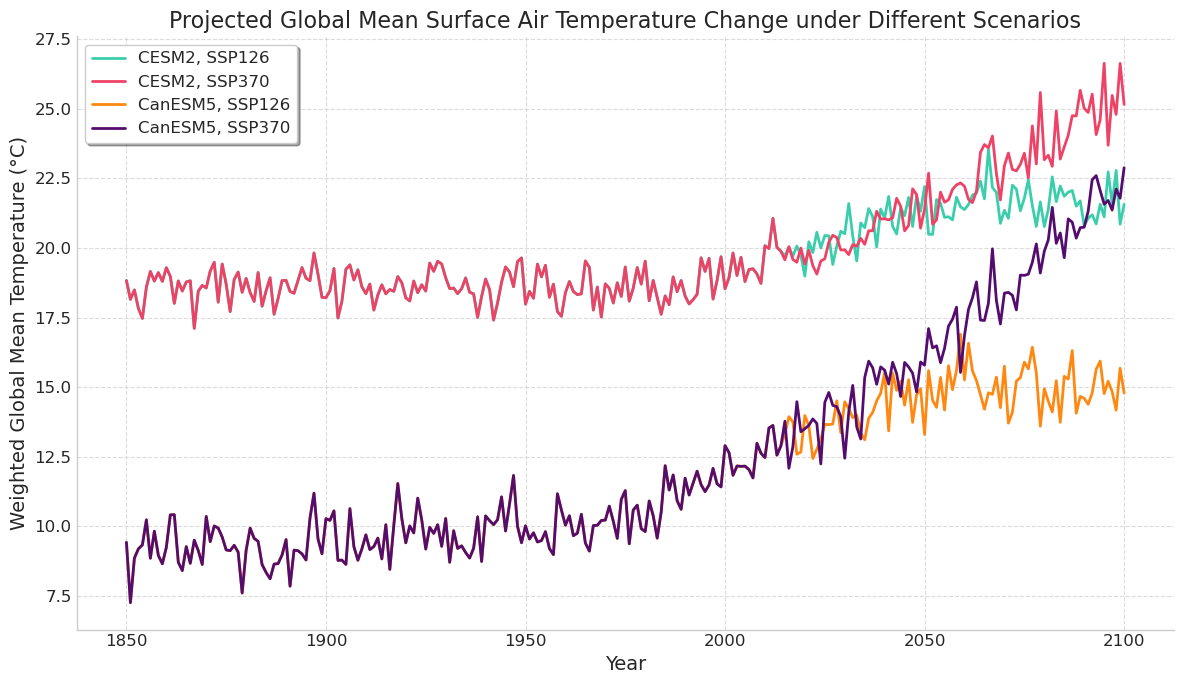

In [183]:
plt.style.use('seaborn-v0_8-whitegrid') 
plt.figure(figsize=(12, 7))
mpl.rcParams.update({'font.size': 12, 'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 12})
plt.plot(cesm_annual_mean_126.year, cesm_annual_mean_126, label='CESM2, SSP126', color='#3bceac', linewidth=2)
plt.plot(cesm_annual_mean_370.year, cesm_annual_mean_370, label='CESM2, SSP370', color='#ee4266', linewidth=2)
plt.plot(can_annual_mean_126.year, can_annual_mean_126, label='CanESM5, SSP126', color='#ff8811', linewidth=2)
plt.plot(can_annual_mean_370.year, can_annual_mean_370, label='CanESM5, SSP370', color='#540d6e', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Weighted Global Mean Temperature (°C)') 
plt.title('Projected Global Mean Surface Air Temperature Change under Different Scenarios')
plt.legend(loc='best', frameon=True, shadow=True) # 'best' tries to find an optimal location
plt.grid(True, linestyle='--', alpha=0.7) # Make grid lines dashed and slightly transparent

ax = plt.gca() # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 10. Ensure layout is tight to prevent labels overlapping
plt.tight_layout()

# --- Display the plot ---
plt.show()

### Calculate Line of Best Fit and Plot Trend Line
Choose CanESM5 Model and SSP 370 scenario

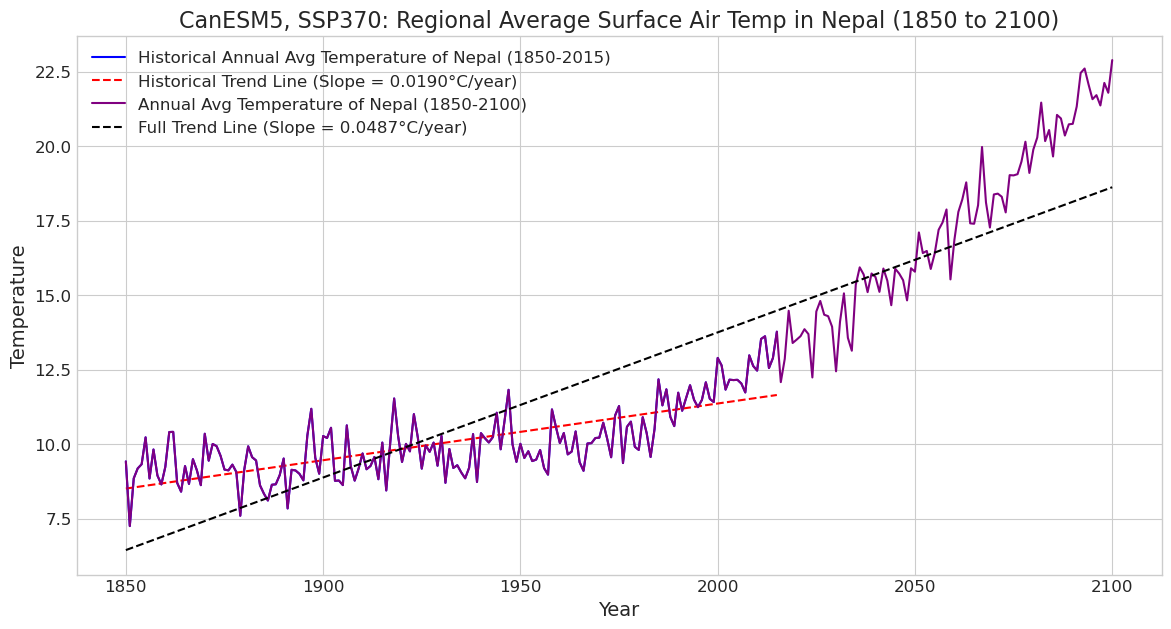

In [184]:
### Fit a trend line for two different time periods
model_data = can_annual_mean_370
model_label = 'CanESM5, SSP370'

# --- 2. Filter Data for Time Periods ---
# Make sure your data covers these years
hist_data = model_data.sel(year=slice(1850, 2015))
full_data = model_data.sel(year=slice(1850, 2100))

# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x = np.polyfit(hist_data.year, hist_data, 1)
# Generate a polynomial object using those best-fit parameters
trend_line = np.poly1d(x)  

y = np.polyfit(full_data.year, full_data, 1)
# Generate a polynomial object using those best-fit parameters
trend_line_full = np.poly1d(y)  

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(hist_data.year, hist_data, label= 'Historical Annual Avg Temperature of Nepal (1850-2015)', color='blue')
ax.plot(hist_data.year, trend_line(hist_data.year), color='red', linestyle='--', label=f'Historical Trend Line (Slope = {x[0]:.4f}°C/year)')
ax.plot(full_data.year, full_data, label= 'Annual Avg Temperature of Nepal (1850-2100)', color='purple')
ax.plot(full_data.year, trend_line_full(full_data.year), color='black', linestyle='--', label=f'Full Trend Line (Slope = {y[0]:.4f}°C/year)')

ax.set_title('CanESM5, SSP370: Regional Average Surface Air Temp in Nepal (1850 to 2100)')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

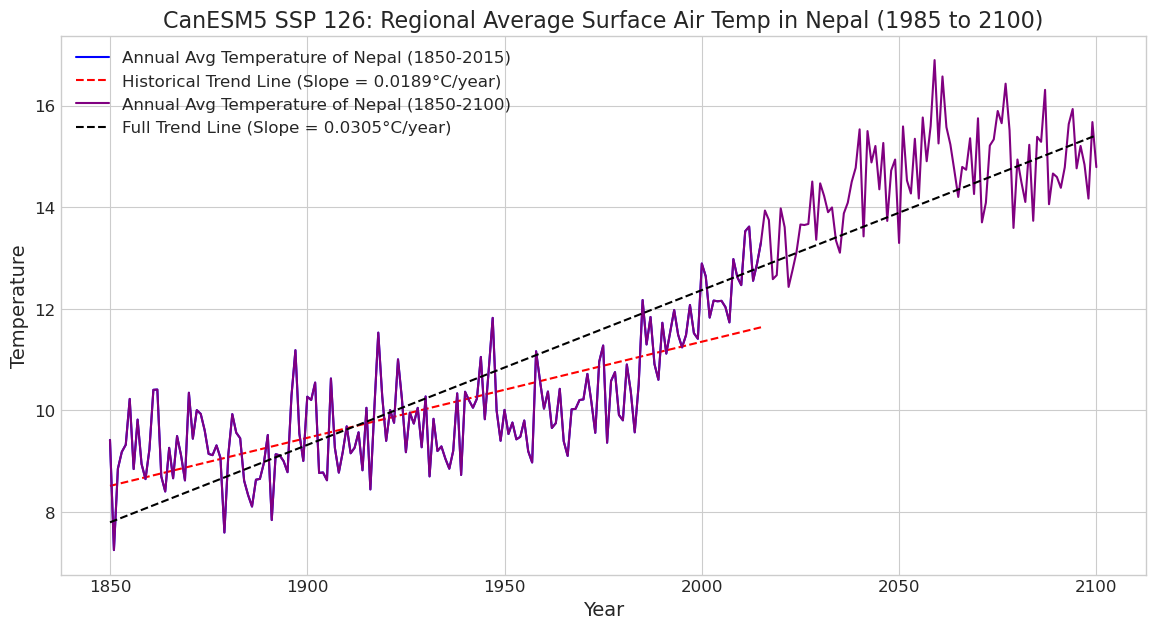

In [185]:
### Fit a trend line for two different time periods
model_data = can_annual_mean_126
model_label = 'CanESM5, SSP126'

# --- 2. Filter Data for Time Periods ---
# Make sure your data covers these years
hist_data = model_data.sel(year=slice(1850, 2015))
full_data = model_data.sel(year=slice(1850, 2100))

# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x = np.polyfit(hist_data.year, hist_data, 1)
# Generate a polynomial object using those best-fit parameters
trend_line = np.poly1d(x)  

y = np.polyfit(full_data.year, full_data, 1)
# Generate a polynomial object using those best-fit parameters
trend_line_full = np.poly1d(y)  

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(hist_data.year, hist_data, label= 'Annual Avg Temperature of Nepal (1850-2015)', color='blue')
ax.plot(hist_data.year, trend_line(hist_data.year), color='red', linestyle='--', label=f'Historical Trend Line (Slope = {x[0]:.4f}°C/year)')
ax.plot(full_data.year, full_data, label= 'Annual Avg Temperature of Nepal (1850-2100)', color='purple')
ax.plot(full_data.year, trend_line_full(full_data.year), color='black', linestyle='--', label=f'Full Trend Line (Slope = {y[0]:.4f}°C/year)')

ax.set_title('CanESM5 SSP 126: Regional Average Surface Air Temp in Nepal (1985 to 2100)')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

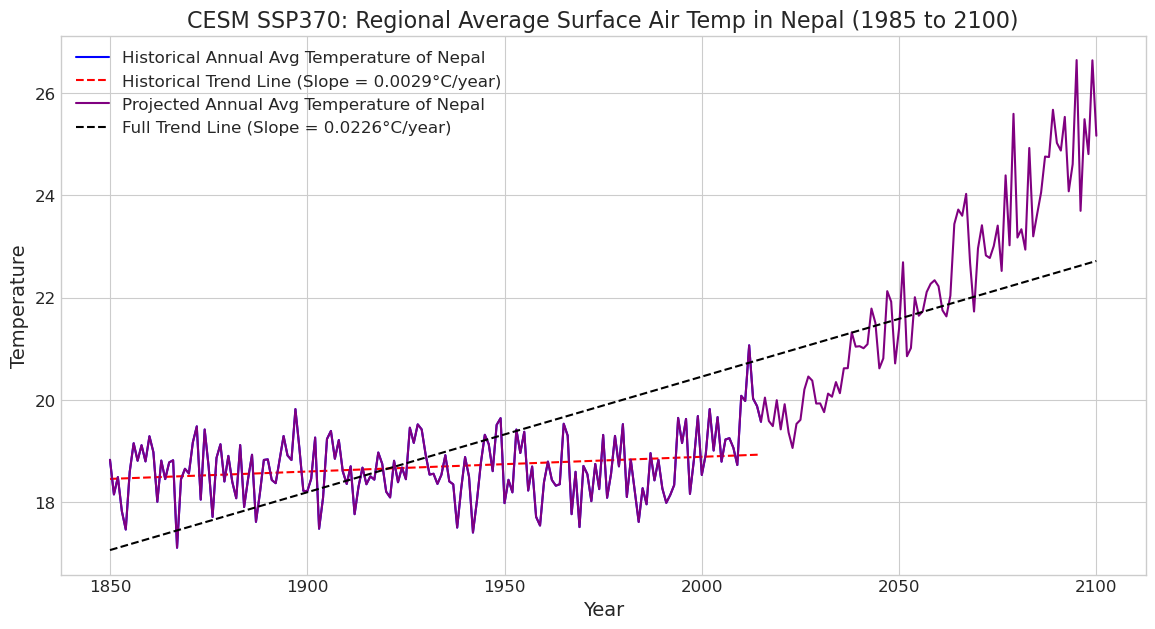

In [186]:
### Fit a trend line for two different time periods
model_data = cesm_annual_mean_370
model_label = 'CESM, SSP370'

# --- 2. Filter Data for Time Periods ---
# Make sure your data covers these years
hist_data = model_data.sel(year=slice(1850, 2015))
full_data = model_data.sel(year=slice(1850, 2100))

# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x = np.polyfit(hist_data.year, hist_data, 1)
# Generate a polynomial object using those best-fit parameters
trend_line = np.poly1d(x)  

y = np.polyfit(full_data.year, full_data, 1)
# Generate a polynomial object using those best-fit parameters
trend_line_full = np.poly1d(y)  

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(hist_data.year, hist_data, label= 'Historical Annual Avg Temperature of Nepal', color='blue')
ax.plot(hist_data.year, trend_line(hist_data.year), color='red', linestyle='--', label=f'Historical Trend Line (Slope = {x[0]:.4f}°C/year)')
ax.plot(full_data.year, full_data, label= 'Projected Annual Avg Temperature of Nepal', color='purple')
ax.plot(full_data.year, trend_line_full(full_data.year), color='black', linestyle='--', label=f'Full Trend Line (Slope = {y[0]:.4f}°C/year)')

ax.set_title('CESM SSP370: Regional Average Surface Air Temp in Nepal (1985 to 2100)')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

### Compare change between best fit line

In [188]:
# For historical period (1850-2015)
slope1, intercept1, r_value1, p_value1, stderr1 = stats.linregress(hist_data.year.values, hist_data.values)

# For full period (1850-2100)
slope2, intercept2, r_value2, p_value2, stderr2 = stats.linregress(full_data.year.values, full_data.values)

print(f"Historical Slope (1850-2015): {slope1:.4f}, Standard Error: {stderr1:.4f}")
print(f"Full Period Slope (1850-2100): {slope2:.4f}, Standard Error: {stderr2:.4f}")

# --- Test the difference between slopes (with caveats about non-independence) ---
# Calculate the difference in slopes
slope_diff = slope1 - slope2

# Calculate the pooled standard error for the difference
# NOTE: This formula assumes independence, which is violated here.
pooled_stderr = np.sqrt(stderr1**2 + stderr2**2)

# Calculate the Z-statistic
# Avoid division by zero if pooled_stderr is extremely small
if pooled_stderr > 1e-9:
    z_stat = slope_diff / pooled_stderr
    # Calculate the two-tailed p-value from the Z-statistic
    p_value_diff = 2 * (1 - stats.norm.cdf(abs(z_stat)))
else:
    z_stat = np.inf # Or some indicator of an issue
    p_value_diff = 0.0 # If slopes are identical and errors are zero

print(f"\n--- Comparison of Slopes ---")
print(f"Difference in slopes: {slope_diff:.4f}")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value for difference: {p_value_diff:.4f}")

# --- Interpretation ---
alpha = 0.05 # Significance level
if p_value_diff < alpha:
    print(f"\nResult: The difference between the slopes is statistically significant at alpha={alpha} (p={p_value_diff:.4f}).")
else:
    print(f"\nResult: The difference between the slopes is not statistically significant at alpha={alpha} (p={p_value_diff:.4f}).")

Historical Slope (1850-2015): 0.0029, Standard Error: 0.0010
Full Period Slope (1850-2100): 0.0226, Standard Error: 0.0011

--- Comparison of Slopes ---
Difference in slopes: -0.0197
Z-statistic: -13.3396
P-value for difference: 0.0000

Result: The difference between the slopes is statistically significant at alpha=0.05 (p=0.0000).


### Discussion

3. a: Describe, in markdown text, the climate of that region in general terms. What is it like? Is it a forest, a desert, polar, tropical,urban, etc? What types of climate change impacts might you expect there?

- Nepal's climate is highly diverse due to its varied topography, ranging from the lowlands of the Terai to the high Himalayas. It experiences a monsoon-influenced climate with distinct seasons, including a hot, dry pre-monsoon summer, a warm and humid monsoon with heavy rainfall, a mild post-monsoon autumn, and a cold, dry winter with snowfall in mountainous regions. The landscape transitions from tropical and subtropical zones in the southern Terai, characterized by hot, humid conditions and fertile plains, to temperate zones in the mid-hills with moderate climates and terraced farmland, and finally to alpine zones in the high Himalayas, marked by harsh cold, glaciers, and sparse vegetation. Climate change poses significant challenges, including rising temperatures that accelerate glacial melt, altered ecosystems, and potential heatwaves, along with erratic precipitation patterns that heighten risks of floods, landslides, and droughts, as well as glacial lake outburst floods (GLOFs), threatening long-term water availability.

4. Over both of those time periods, is the temperature of your region changing, and is that change statistically significant?

- The region exhibits a statistically significant warming trend over both the historical period (1850–2015) and the full period (1850–2100) for both models. For CESM2, the historical warming rate has a slope of 0.0029 and the full period, including future projections under the SSP370 scenario, shows a steeper slope of 0.0226, indicating accelerated warming. The statistical significance of these trends is supported by the slopes being substantially larger than their respective standard errors, and the difference between the historical and full-period warming rates is confirmed as statistically significant (p = 0.0000), highlighting a much faster rate of temperature increase when future projections are included.

5. Write 1-2 paragraphs in markdown text describing the results of your plot, and what you think they might mean for humans or ecosystems located in your study region.

- The analysis comparing historical (1850-2015) and projected future temperature trends for Nepal reveals a clear and statistically significant acceleration of warming across all examined scenarios and models. Both the CanESM5 and CESM2 climate models show that the rate of warming projected for the 21st century under both the low-emissions SSP126 and the medium-to-high emissions SSP370 scenarios is significantly steeper than the trend observed during the historical period. This indicates that the warming Nepal has already experienced is expected to intensify considerably in the coming decades. While both future scenarios depict accelerated warming compared to the past, the magnitude of this acceleration is substantially greater under the SSP370 scenario in both models, leading to a much faster temperature increase and a significantly warmer end-of-century outcome compared to the SSP126 pathway.

- The consistency between CanESM5 and CESM2 in projecting this accelerated warming relative to the historical baseline strengthens confidence in these findings. For Nepal, this means that the environmental and societal challenges associated with rising temperatures are set to escalate. Compared to historical conditions, future Nepal under either scenario faces amplified risks related to glacial melt and water resource variability, shifts in agricultural zones, altered monsoon dynamics, and increased stress on its unique mountain ecosystems. However, the severity of these impacts diverges sharply between the scenarios: the SSP370 pathway points towards far more drastic and potentially unmanageable changes compared to the historical baseline and the SSP126 scenario, emphasizing the critical difference global mitigation efforts make for Nepal's future climate and the adaptation burden it will face.